# Import Libraries & Data

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from helpers import *
from variables import *

In [216]:
# load raw movie/user features
movie_raw_features,user_raw_features = load_raw_features()

# load raw ratings
ratings = pd.read_csv('data/u.data',sep='\t',names=['user id','movie id','rating','timestamp'])

# Ratings

In [217]:
ratings.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [218]:
ratings.dtypes

user id      int64
movie id     int64
rating       int64
timestamp    int64
dtype: object

In [219]:
# engineer an avg. rating per movie feature
avg_ratings = ratings.groupby('movie id')['rating'].mean().reset_index().rename(columns={'rating':'avg rating'})

In [220]:
# save ratings 
np.save("cleaned_data/targets.npy",ratings['rating'].to_numpy())

# Movie Features

In [272]:
df = pd.DataFrame(movie_raw_features,columns=movie_raw_features_headers)

## Preprocessing

In [273]:
# create a new column 'Release Year' from 'release date'
df['Release Year']=pd.to_datetime(df['release date']).dt.year.astype(float)
# drop release data column
df.drop(columns=['release date'],inplace=True)

print("'video release date' is an empty column:",df['video release date'].unique())
# drop video release date column
df.drop(columns=['video release date'],inplace=True)

'video release date' is an empty column: ['']


In [274]:
# change dtype of numerical columns from object to float
cols_to_float = [0] + list(range(3,22))
for col in df.columns[cols_to_float]:
    df[col] = df[col].astype(float)
df.dtypes

movie id        float64
movie title      object
IMDb URL         object
unknown         float64
Action          float64
Adventure       float64
Animation       float64
Children's      float64
Comedy          float64
Crime           float64
Documentary     float64
Drama           float64
Fantasy         float64
Film-Noir       float64
Horror          float64
Musical         float64
Mystery         float64
Romance         float64
Sci-Fi          float64
Thriller        float64
War             float64
Western         float64
Release Year    float64
dtype: object

In [275]:
# enrich each movie with avg rating
df = df.merge(right=avg_ratings,on='movie id',how='left')

In [270]:
# save movie vectors
np.save("cleaned_data/movie_vecs",df.iloc[:,3:].to_numpy())

Our training data will have length 100000 because that's how many user ratings we have. Thus, we need to duplicate movie feature rows as many times as they are rated so that we can use them when training the model.

In [225]:
# df_extended shape (100000, 24)
df_extended = df.merge(right=ratings['movie id'],how='right')

In [226]:
# save data as numpy array
df_array = df_extended.to_numpy()
np.save("cleaned_data/movie_features.npy",df_array)
# save headers as numpy array
df_headers = df_extended.columns.to_numpy()
np.save("cleaned_data/movie_features_headers.npy",df_headers)

In [254]:
# create a movie dictionary to map movie ids to titles and genres
genres = df_extended.columns[3:-2]
movie_df = pd.concat([df[['movie id', 'movie title']],df[genres].apply(lambda row: "|".join([genre for genre in genres if row[genre] == 1]), axis=1)],axis=1).rename(columns={0:'genres'})
movie_dict = movie_df.set_index("movie id")[["movie title", "genres"]].T.to_dict("list")

with open("cleaned_data/movie_dict.pkl","wb") as f:
    pickle.dump(movie_dict,f)

## Data Visualisation

In [104]:
genres = ['unknown', 'Action', 'Adventure',
       'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western']

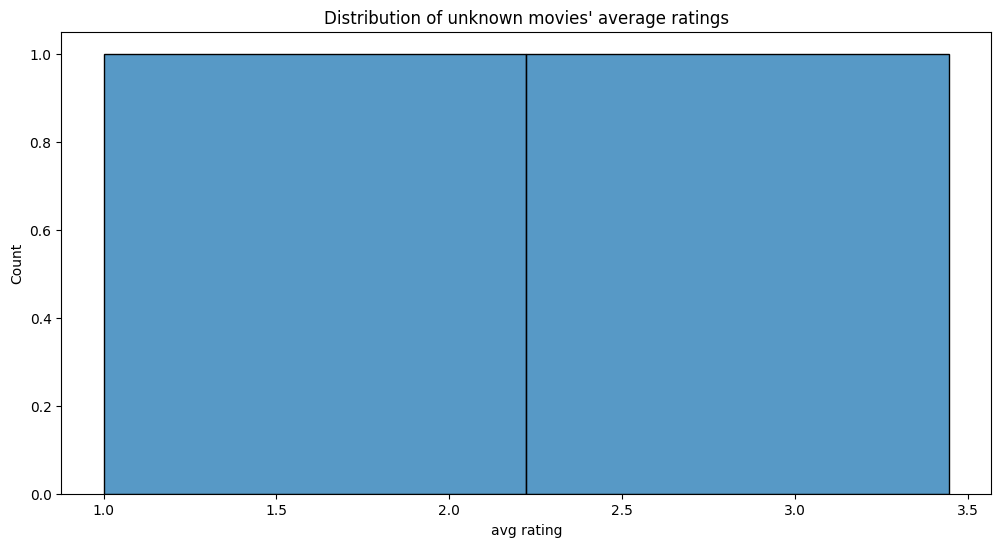

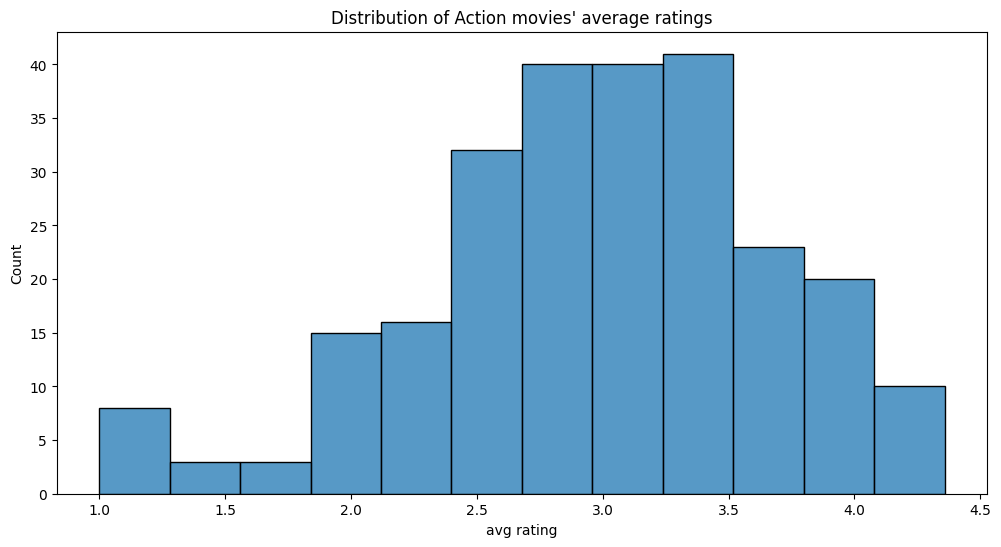

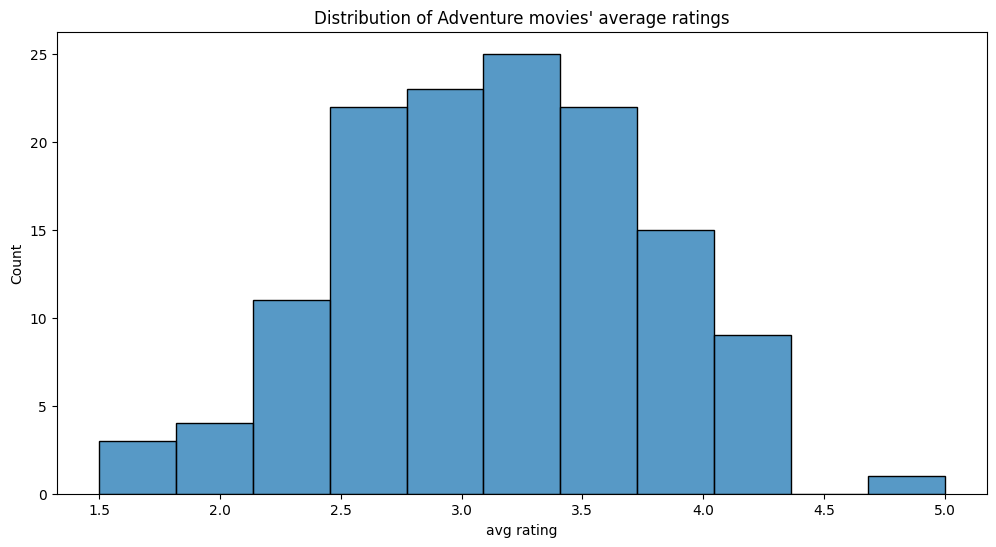

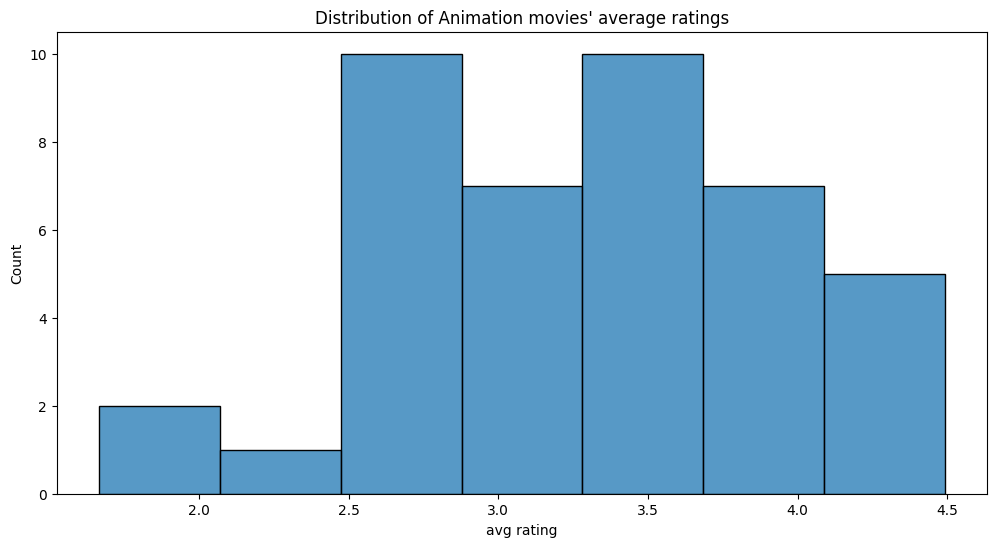

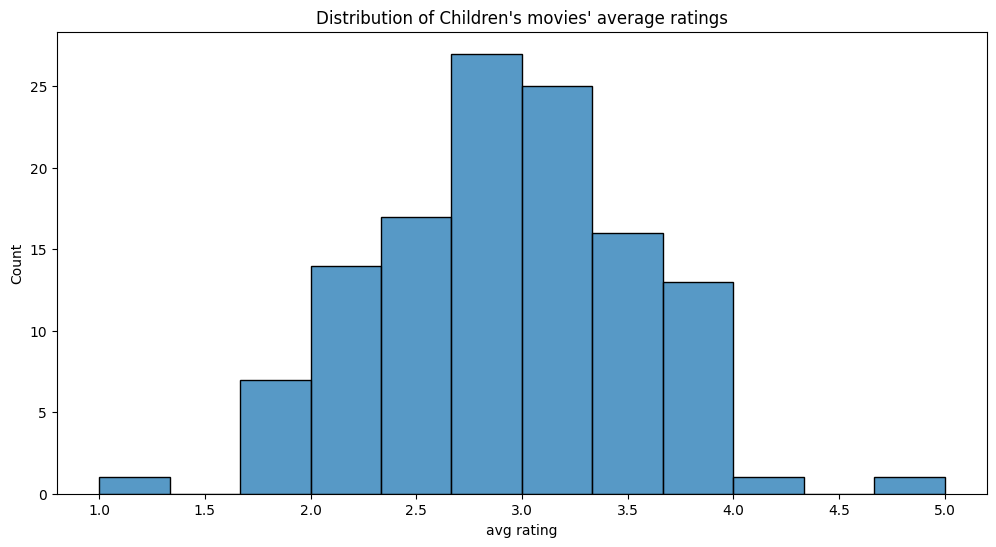

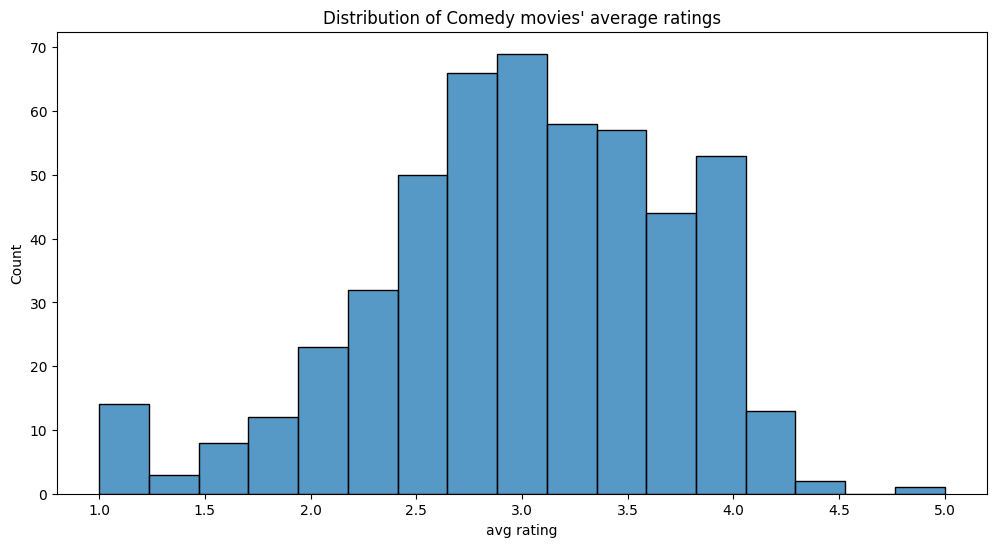

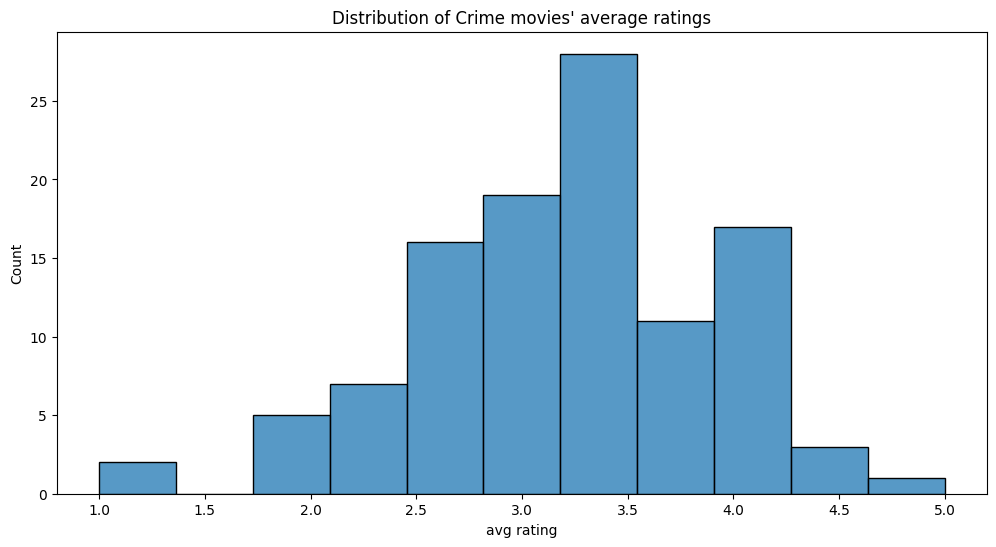

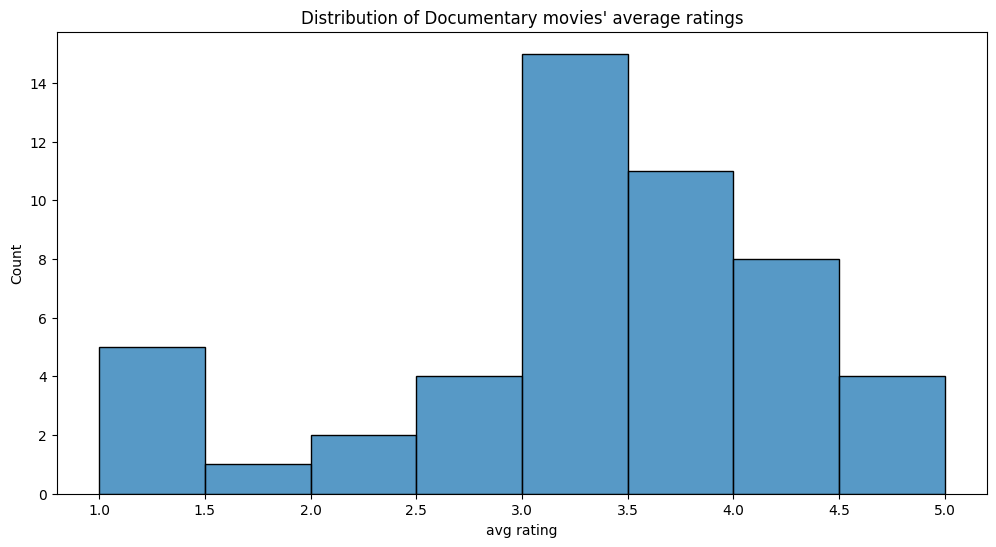

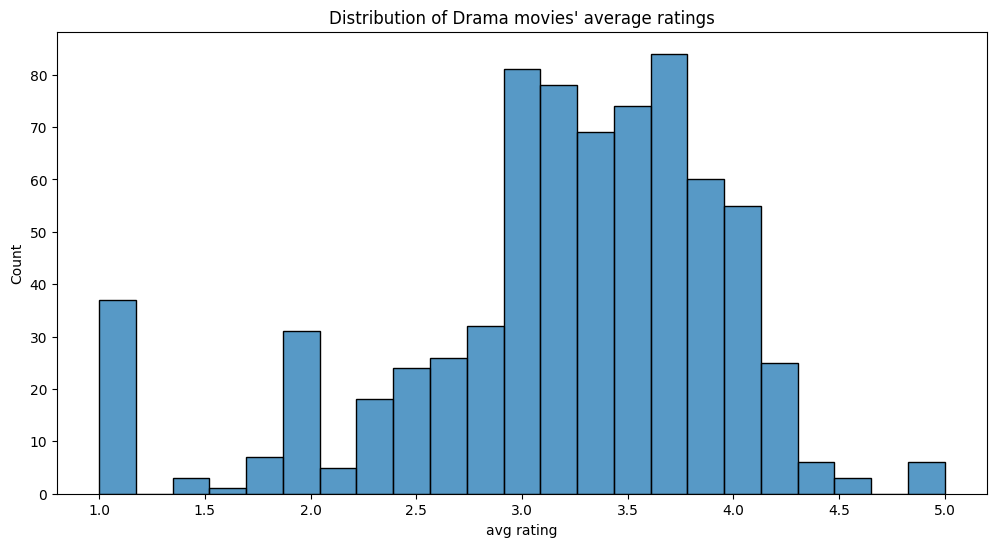

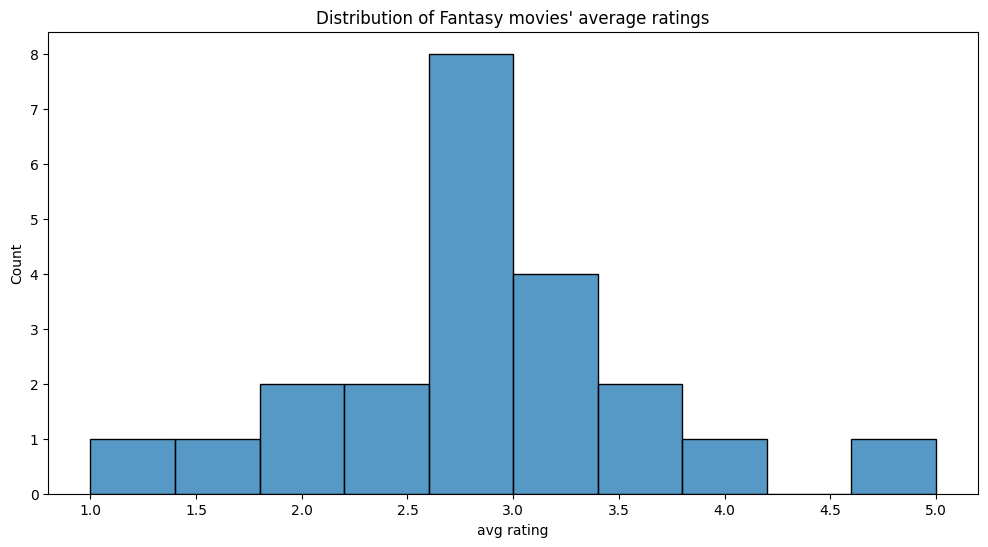

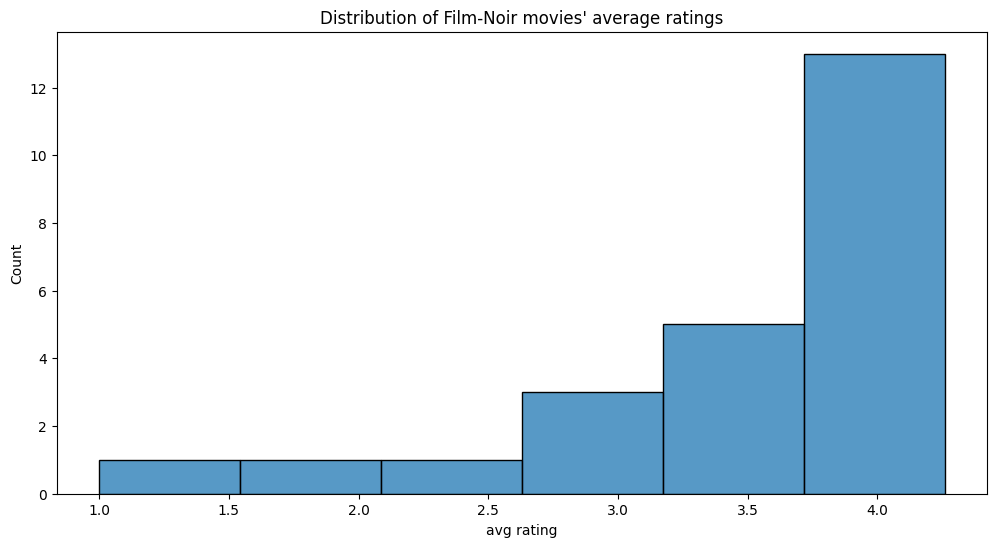

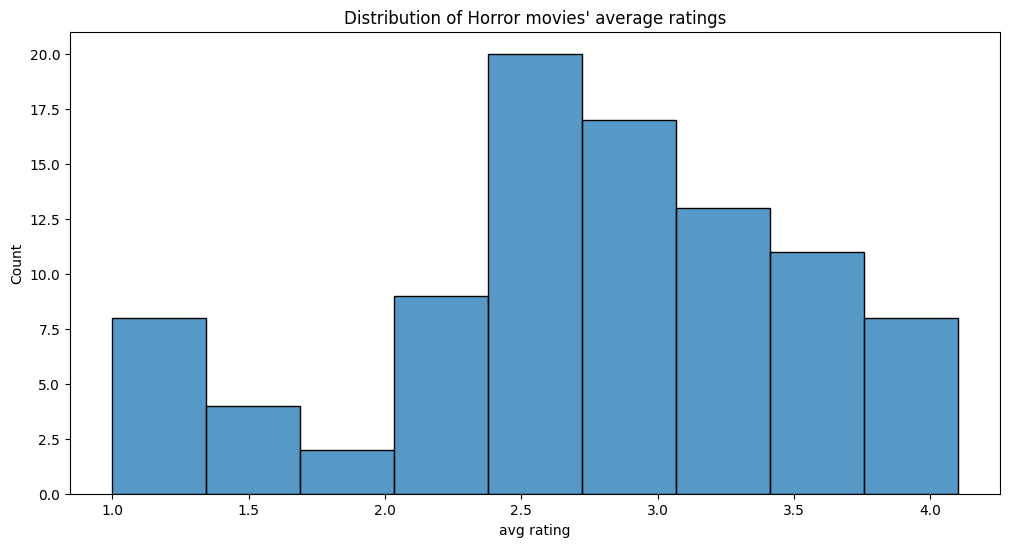

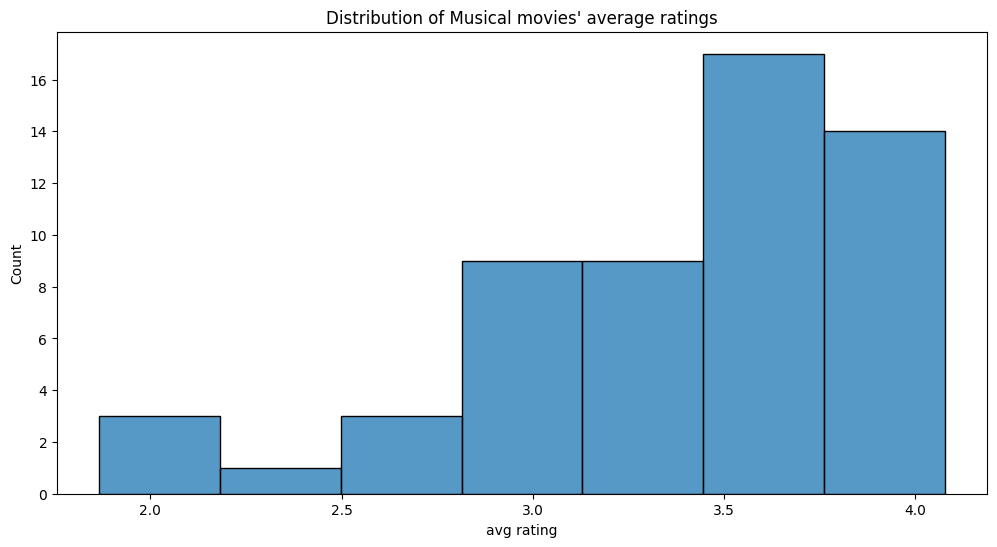

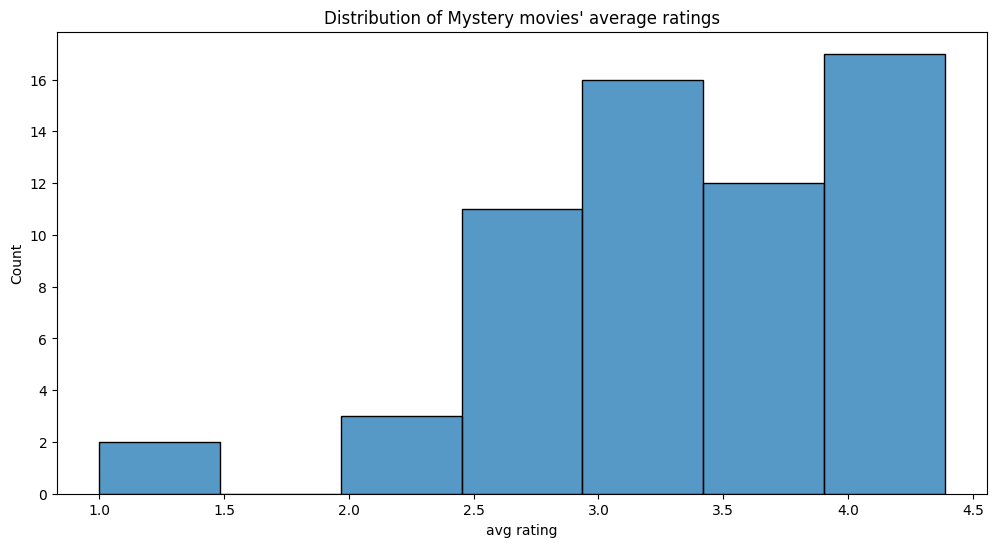

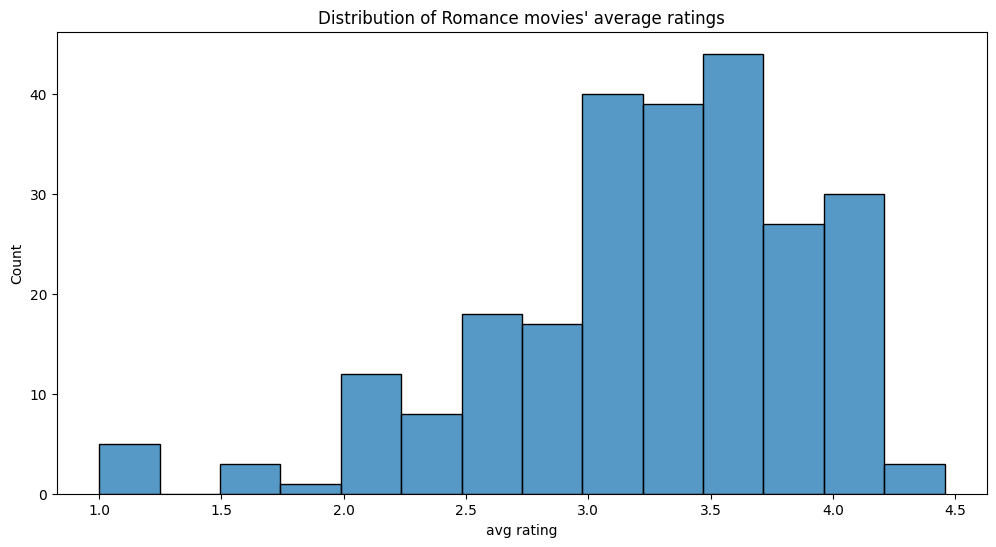

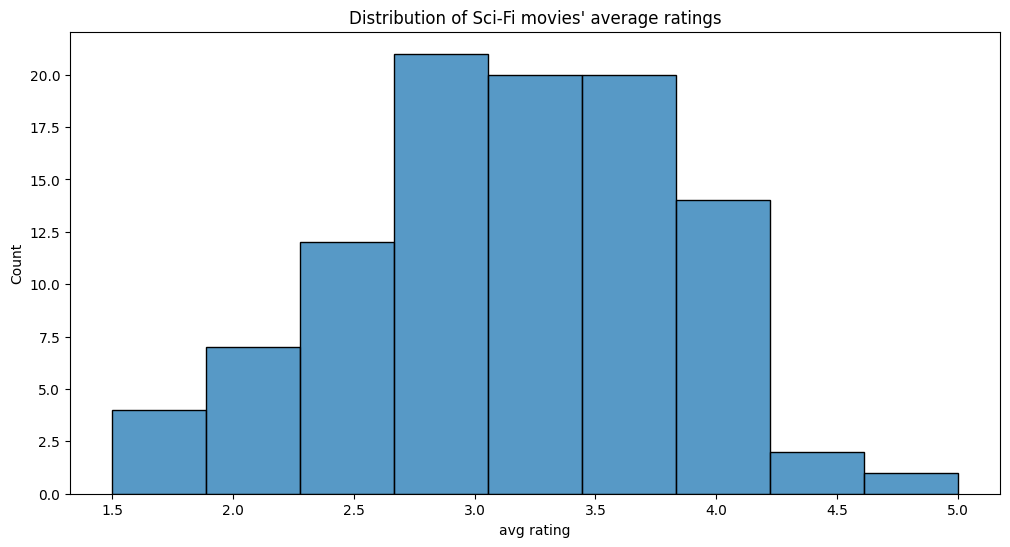

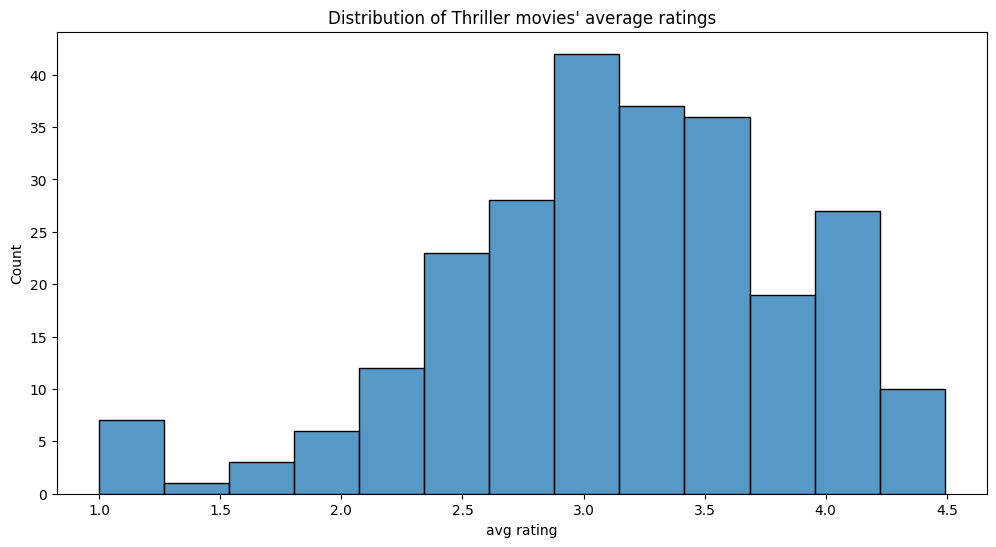

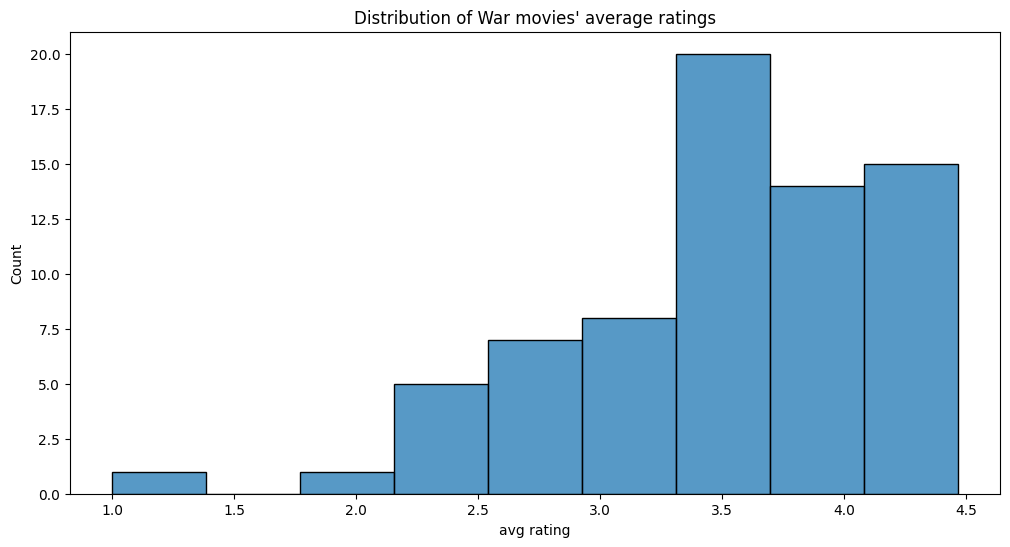

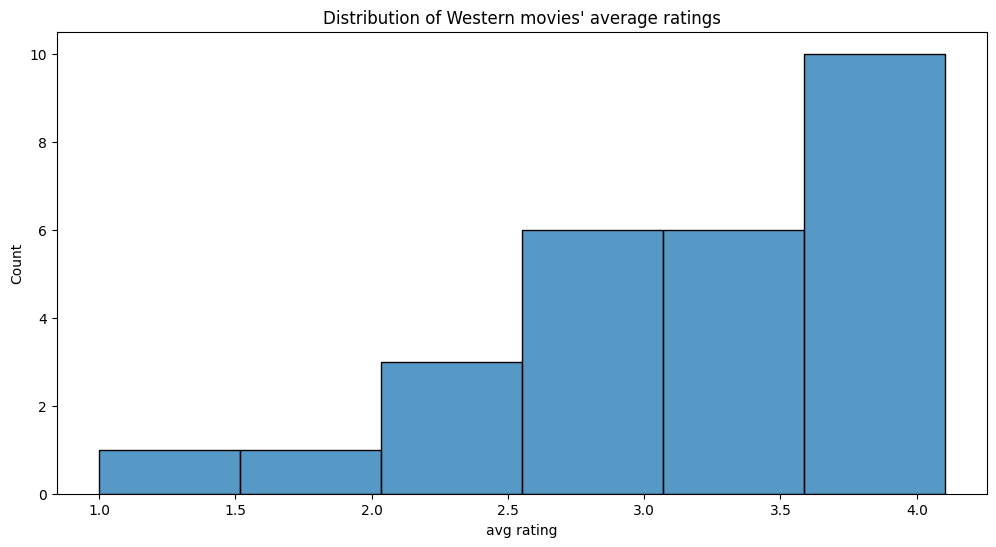

In [105]:
for genre in genres:
    fig, axes = plt.subplots(figsize=(12,6))
    genre_df = df[df[genre]==1]
    sns.histplot(genre_df,x='avg rating')
    plt.title(f"Distribution of {genre} movies' average ratings")


# User Features

## Preprocessing

In [113]:
df = pd.DataFrame(user_raw_features,columns=user_raw_features_headers)

In [114]:
df.dtypes

user id       object
age           object
gender        object
occupation    object
zip code      object
dtype: object

In [115]:
df.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


user id and age columns need to be converted from object to float type. occupation and gender columns are categorical variables that take 21 and 2 possible values respectively; we will one-hot encode these two columns.

In [120]:
# change dtype
for col in df.columns[[0,1]]:
    df[col] = df[col].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user id     943 non-null    float64
 1   age         943 non-null    float64
 2   gender      943 non-null    object 
 3   occupation  943 non-null    object 
 4   zip code    943 non-null    object 
dtypes: float64(2), object(3)
memory usage: 37.0+ KB


In [ ]:
# one-hot encode categorical variables
dummies=pd.get_dummies(df[['gender','occupation']]).astype(float)
df_encoded = pd.concat([df,dummies],axis=1).drop(columns=['gender','occupation'])

# swap age and zip columns around
cols = list(df_encoded.columns)
idx1=cols.index('age')
idx2=cols.index('zip code')
cols[idx1],cols[idx2] = cols[idx2],cols[idx1]
df_encoded=df_encoded[cols]

# change column names
df_encoded.columns = list(df_encoded.columns[:3])+['female','male']+headers


In [204]:
df_encoded.head()

,user id,zip code,age,female,male,administrator,artist,doctor,educator,engineer,...,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
0,1.0,85711,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,94043,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,32067,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.0,43537,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,15213,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
df_encoded_extended = df_encoded.merge(right=ratings['user id'],how='right')
print("df_encoded_extended shape:",df_encoded_extended.shape)

df_encoded_extended shape: (100000, 26)


In [206]:
# save df
np.save("cleaned_data/user_features.npy",df_encoded_extended.to_numpy())
# save headers
np.save("cleaned_data/user_features_headers.npy",df_encoded_extended.columns.to_numpy())

Data Visualisation

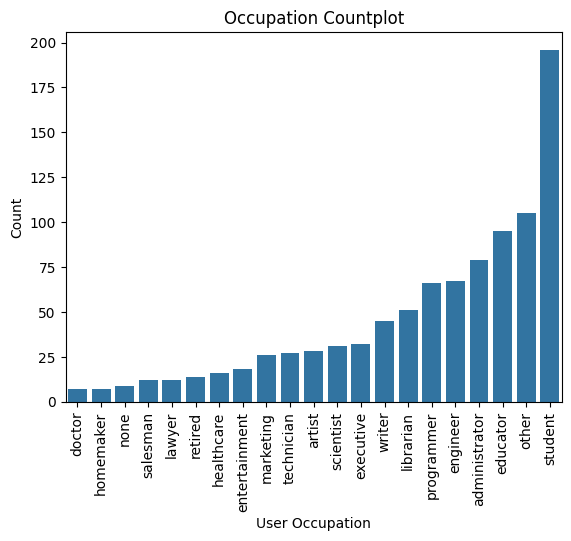

In [202]:
order = df['occupation'].value_counts().sort_values(ascending=True).index
sns.countplot(df,x='occupation', order = order)
plt.title("Occupation Countplot")
plt.xticks(rotation =90)
plt.ylabel('Count')
plt.xlabel('User Occupation')
plt.show()

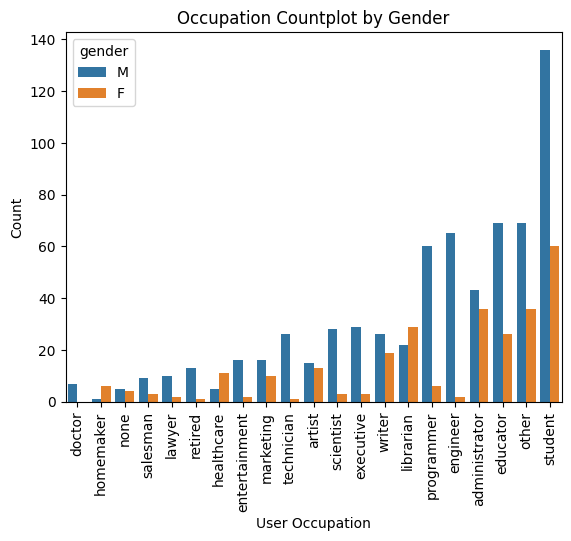

In [201]:
order = df['occupation'].value_counts().sort_values(ascending=True).index
sns.countplot(df,x='occupation',hue='gender',order=order)
plt.title("Occupation Countplot by Gender")
plt.xticks(rotation =90)
plt.ylabel('Count')
plt.xlabel('User Occupation')
plt.show()

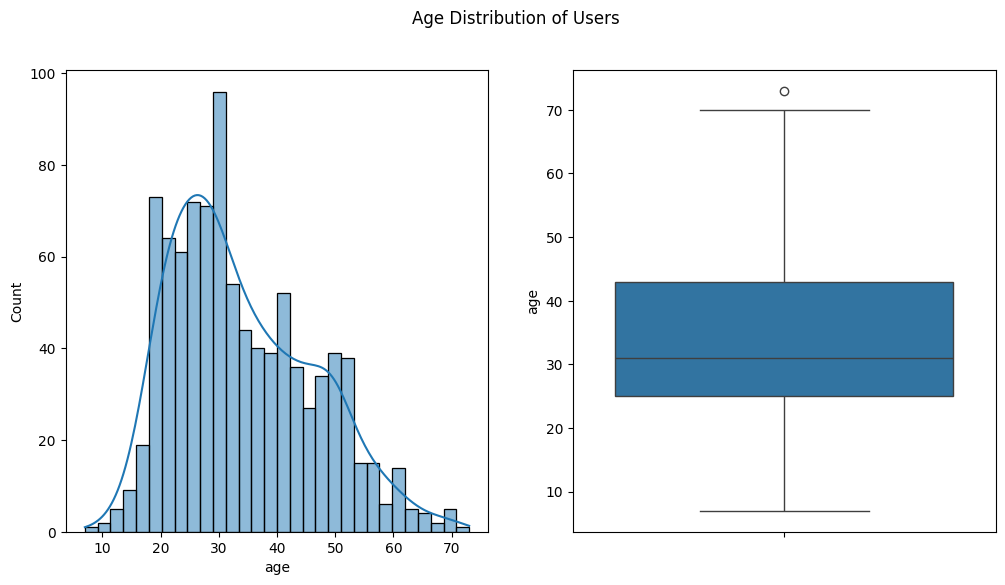

In [211]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
sns.histplot(df,x='age',bins=30,kde=True,ax=axes[0])
sns.boxplot(df,y='age',ax=axes[1])
plt.suptitle("Age Distribution of Users")
plt.show()